In [1]:
import os
import random
import numpy as np

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, convolve1d
import shutil
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
from scipy.stats import norm
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F

In [2]:
image_path = '/Users/hatwa/Downloads/utk_sample/utk_sample/'

In [3]:
test_split = 0.1
valid_split =0.1
BATCH_SIZE = 20

In [4]:
os.mkdir("/Users/hatwa/Downloads/utk_sample/train/")
os.mkdir("/Users/hatwa/Downloads/utk_sample/test/")
os.mkdir("/Users/hatwa/Downloads/utk_sample/valid/")

In [5]:
# Getting the age from the images names
labels = []
for filename in os.listdir(image_path):
    age = int(filename.split("_")[0])
    labels.append(age)

In [6]:
# Splitting the dataset into test, train and validation folders
number_images = len(labels)
max_age = max(labels)

number_test_images = int(test_split * number_images)
number_valid_images = int(valid_split * number_images)
number_train_images = number_images - number_test_images - number_valid_images

all_images_filenames = [f for f in os.listdir("/Users/hatwa/Downloads/utk_sample/utk_sample/") 
                        if os.path.isfile(os.path.join("/Users/hatwa/Downloads/utk_sample/utk_sample/", f))]

#select random test images from all images
test_images_filenames = random.sample(all_images_filenames, number_test_images)
    
#remove test images from all images    
all_images_filenames = [img for img in all_images_filenames if img not in test_images_filenames]

valid_images_filenames = random.sample(all_images_filenames, number_valid_images)


for x in test_images_filenames:
    shutil.copy("/Users/hatwa/Downloads/utk_sample/utk_sample/"+"/"+x, "/Users/hatwa/Downloads/utk_sample/test/"+"/"+x)

for x in valid_images_filenames:
    shutil.copy("/Users/hatwa/Downloads/utk_sample/utk_sample/"+"/"+x, "/Users/hatwa/Downloads/utk_sample/valid/"+"/"+x)
    
all_images_filenames = [img for img in all_images_filenames if img not in valid_images_filenames]

for x in all_images_filenames:
    shutil.copy("/Users/hatwa/Downloads/utk_sample/utk_sample/"+"/"+x, "/Users/hatwa/Downloads/utk_sample/train/"+"/"+x)


In [7]:
# Image augmentation
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(-40, 40)),
    transforms.RandomGrayscale(),
    transforms.RandomInvert(),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ColorJitter(brightness=[0.4, 1.4], contrast=[0.4, 1.6], saturation=[0.4, 1.6]),
    transforms.ToTensor(),
    transforms.Normalize([0.6, 0.5, 0.4], [0.1, 0.1, 0.1])
])

In [8]:
def load_dataset(image_path):
    labels = []
    filenames = []
    for filename in os.listdir(image_path):
        age = int(filename.split("_")[0])
        labels.append(age)
        filenames.append(filename)
    return labels, filenames

def load_image(image_filenames, image_path):
    images = []
    for filename in image_filenames:
        image = cv2.imread(image_path + filename)
        image = cv2.resize(image, (200, 200))
   #     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = torchvision.transforms.functional.to_tensor(image)      
        images.append(image)
    return images

In [9]:
# Define the LDS kernel window
def get_lds_kernel_window(ks, sigma):
    half_ks = (ks - 1) // 2
    base_kernel = [0.] * half_ks + [1.] + [0.] * half_ks
    kernel_window = gaussian_filter1d(base_kernel, sigma=sigma) / max(gaussian_filter1d(base_kernel, sigma=sigma))
    return kernel_window

In [10]:
class CustomImageDataset(Dataset):
    def __init__(self, image_path, labels, lds = False, ks=5, sigma=2, transforms = augmentation_transforms):
        self.image_labels, self.image_filenames = load_dataset(image_path)
        self.loaded_images = load_image(self.image_filenames, image_path)
        self.transforms = transforms
        self.PILTransforms = torchvision.transforms.ToPILImage()
        self.images = []
        
        for image in self.loaded_images:
            image = self.PILTransforms(image)
            image = self.transforms(image)
            self.images.append(image)
            
        self.lds = lds
        self.weights = self.prepare_weights(self.image_labels, self.lds, ks=ks, sigma=sigma)
        
    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):   
        if self.lds:
            return self.images[idx], self.image_labels[idx], self.weights[idx]
        else:
            return self.images[idx], self.image_labels[idx]

# Perform LDS and calculate weights based on the smoothened label frequency
    def prepare_weights(self, labels, lds, ks, sigma):
        max_target = max(labels)
        value_dict = {x: 0 for x in range(max_target)}
    
        if self.lds:      
            for label in labels:
                value_dict[min(max_target - 1, int(label))] += 1
            
            value_dict = {k: np.sqrt(v) for k, v in value_dict.items()}
            num_per_label = [value_dict[min(max_target - 1, int(label))] for label in labels]

            lds_kernel_window = get_lds_kernel_window(ks, sigma)
            smoothed_value = convolve1d(np.asarray([v for _, v in value_dict.items()]), weights=lds_kernel_window, mode='constant')
            num_per_label = [smoothed_value[min(max_target - 1, int(label))] for label in labels]
            
            weights = [np.float32 (1 /np.sqrt(x)) for x in num_per_label]
            scaling = len(weights) / np.sum(weights)
            weights = [scaling * x for x in weights]
            return weights

In [11]:
dataset_train = CustomImageDataset("/Users/hatwa/Downloads/utk_sample/train/", number_train_images, lds = True, ks = 5, sigma = 1, transforms = augmentation_transforms)
dataset_valid = CustomImageDataset("/Users/hatwa/Downloads/utk_sample/valid/", number_valid_images, lds = False)
dataset_test = CustomImageDataset("/Users/hatwa/Downloads/utk_sample/test/", number_test_images, lds = False)

train_dataloader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_dataloader = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [12]:
#Defining the convolutional neural network
class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 4, kernel_size=(3), padding=1,stride=1)  
   #     self.norm1=nn.BatchNorm2d(4)
        self.conv2 = nn.Conv2d(in_channels = 4, out_channels = 8,kernel_size = (3), padding=1,stride=1)        
   #     self.norm2=nn.BatchNorm2d(8)
        self.conv3 = nn.Conv2d(in_channels = 8, out_channels = 16,kernel_size = (3), padding=1,stride=1) 
   #     self.norm3=nn.BatchNorm2d(16)
        self.conv4 = nn.Conv2d(in_channels = 16, out_channels = 32,kernel_size = (3), padding=1,stride=1) 
   #     self.norm4 = nn.BatchNorm2d(32)
        self.L1 = nn.Linear(32*25*25, 2*25*25)
        self.L2 = nn.Linear(2*25*25, 100)
              
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.act = nn.ReLU()
        self.act1 = nn.Softmax(dim = 1)

    def forward(self, x):
        x = self.conv1(x)
    #    x = self.norm1(x)
        x = self.act(x)
        x = self.pool(x)
        x = self.conv2(x)
    #    x = self.norm2(x)
        x = self.act(x)
        x = self.pool(x)
        x = self.conv3(x)
    #    x = self.norm3(x)
        x = self.act(x)  
        x = self.pool(x)
        x = self.conv4(x)
     #   x = self.norm4(x)
        x = self.act(x)  
        x = x.view(x.size()[0], -1)
        x = self.L1(x)
        x = self.act(x)
        x = self.L2(x)
        x = self.act1(x)
   
        return x

In [17]:
# Defining the loss functions
def kl_loss(outputs, labels, weights):
    max_age = outputs.shape[1]
    log_outputs = torch.log(outputs)
    labels = labels.long()
    # Converting the integer label into one-hot labelling
    onehot_labels = torch.zeros(max_age)
    onehot_labels[labels-1] = 1
    
    # KLdivergence for a batch
    loss = -1 * torch.matmul(log_outputs, onehot_labels.float().t())
    loss = loss/len(loss)
    loss*= weights
    loss = torch.mean(loss)

    return loss

def valid_loss(outputs, mean, var):
    difference = (outputs - mean)**2/(2*var)
    loss = 1 - torch.exp(-difference)
    return loss

In [23]:
model = LeNet(max(labels))

In [24]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=3e-4)
lr_scheduler = StepLR(optimizer, step_size=30, gamma=0.4)
EPOCHS = 100

In [25]:
training_loss_history, validation_loss_history, validation_error_history = [], [], []

for epoch in range(EPOCHS):
    
    #track trianing loss
    training_loss = 0
    training_loss_length = 0
    
    #track validation loss
    validation_loss = 0
    validation_loss_length = 0
    
    validation_error = 0
    validation_error_length = 0
    
    model.train()
    for (x, y, weights) in train_dataloader:
        # Output is the pobability distribution of the ages
        outputs = model(x)
        train_loss = kl_loss(outputs, y, weights)
        # The age with highest probability is the result
        age = torch.argmax(outputs, dim =1)

        training_loss += float(train_loss)
        training_loss_length += 1
        
    #back propagate and optimize   
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    lr_scheduler.step()
    
    #validation 
    model.eval()
    for (x, y) in valid_dataloader:
        outputs = model(x)
        age = torch.argmax(outputs, dim=1)

        loss = valid_loss(age, y, var=9)      
        avg_loss = torch.mean(loss)
        validating_error = kl_loss(outputs, y, weights)
        
        validation_loss += float(avg_loss)
        validation_loss_length += 1
        
        validation_error += float(validating_error)
        validation_error_length += 1
        
    training_loss_history.append(training_loss/training_loss_length)
    validation_loss_history.append(validation_loss/validation_loss_length)
    validation_error_history.append(validation_error/validation_error_length)
    
    print("epoch:" ,epoch, "training loss:{:6.4f}".format(training_loss/training_loss_length), 
          "validation loss:{:6.4f}".format(validation_loss/validation_loss_length),
          "validation error:{:6.4f}".format(validation_error/validation_error_length))
  #  print("training loss:", training_loss/training_loss_length)
   # print("validation loss:", validation_loss/validation_loss_length)
        

epoch: 0 training loss:3.9981 validation loss:0.6751 validation error:3.8196
epoch: 1 training loss:3.6075 validation loss:0.7102 validation error:3.0137
epoch: 2 training loss:3.4993 validation loss:0.7102 validation error:3.6103
epoch: 3 training loss:3.4125 validation loss:0.7102 validation error:3.4013
epoch: 4 training loss:3.3832 validation loss:0.7102 validation error:3.3702
epoch: 5 training loss:3.2517 validation loss:0.7102 validation error:3.4433
epoch: 6 training loss:3.3604 validation loss:0.7102 validation error:3.3080
epoch: 7 training loss:3.4028 validation loss:0.7102 validation error:3.4447
epoch: 8 training loss:3.3573 validation loss:0.7102 validation error:3.5139
epoch: 9 training loss:3.4482 validation loss:0.7102 validation error:3.4218
epoch: 10 training loss:3.3735 validation loss:0.7102 validation error:3.6425
epoch: 11 training loss:3.4393 validation loss:0.7102 validation error:3.6781
epoch: 12 training loss:3.3104 validation loss:0.7102 validation error:3.5

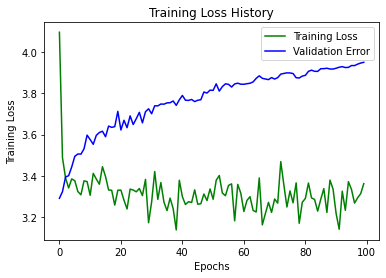

In [21]:
eps = range(0, EPOCHS)
plt.plot(eps, training_loss_history, 'g', label = 'Training Loss')
plt.plot(eps, validation_error_history, 'b', label = 'Validation Error')

plt.title('Training Loss History')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

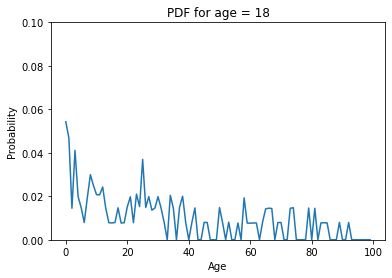

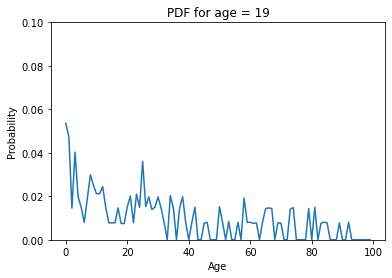

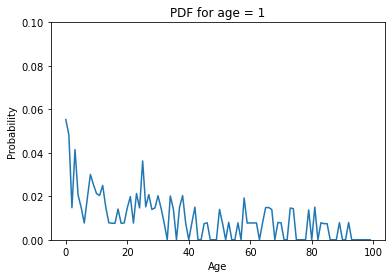

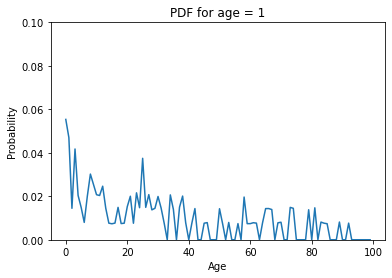

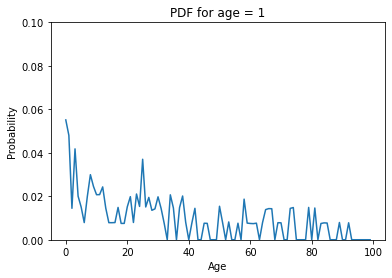

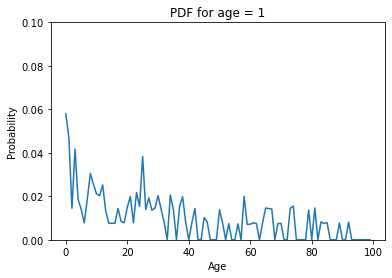

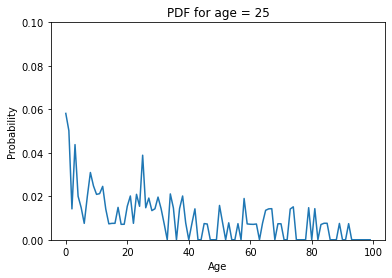

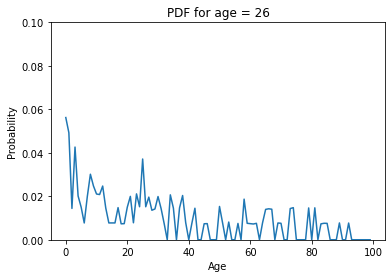

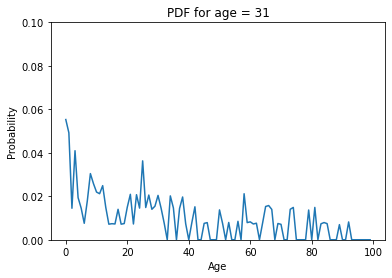

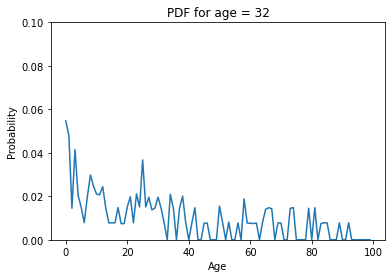

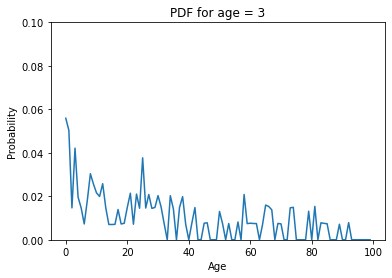

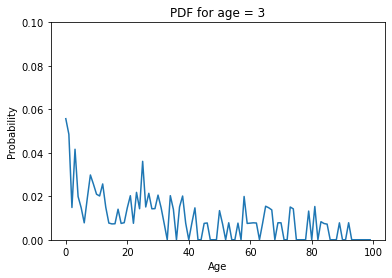

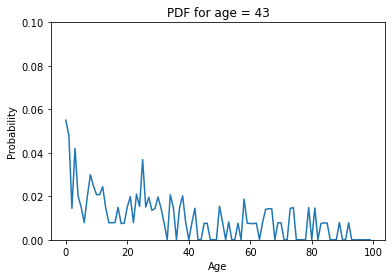

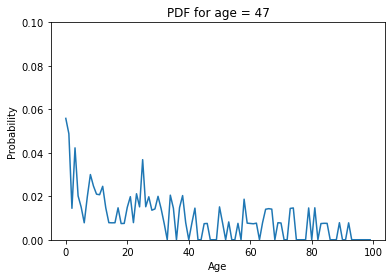

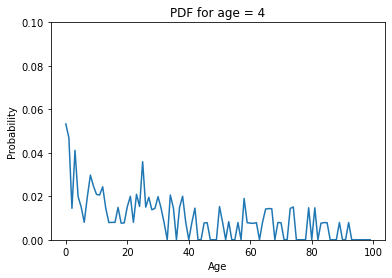

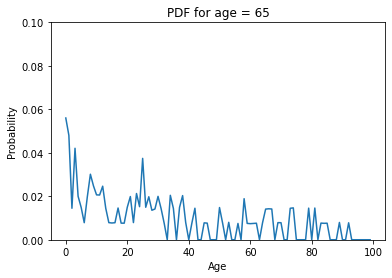

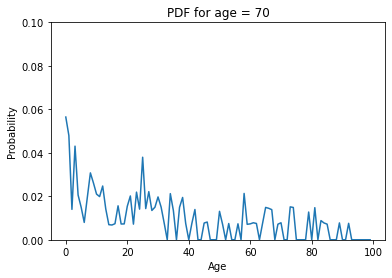

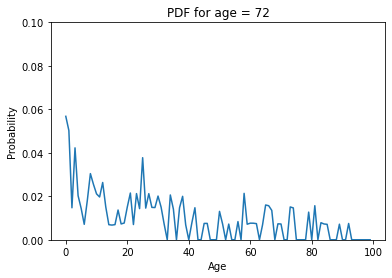

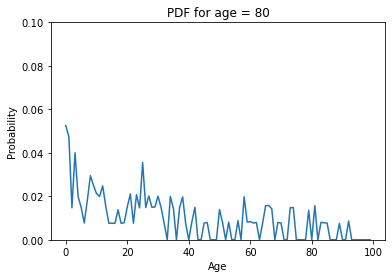

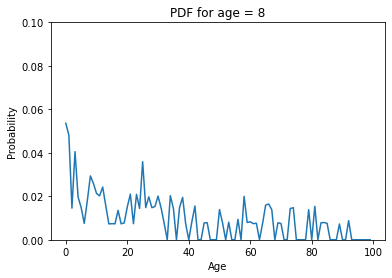

In [22]:
for (x, y) in test_dataloader:
    #predict age
    outputs = model(x)
    age = torch.argmax(outputs,dim=1)+1
    prob_age = outputs.detach().numpy()

    
   # print(onehot_labels)
    
def make_plot(age, i):
    plt.figure()
    plt.plot(prob_age[i])
    plt.title('PDF for age = ' + str(age))
    plt.xlabel('Age')
    plt.ylabel('Probability')
    plt.ylim(0, 0.1)
    plt.show()
    
for i in range(prob_age.shape[0]):
    age = y[i].detach().numpy()
  #  print(onehot_labels[i])
    make_plot(age,i)